In [317]:
import sklearn.datasets
import sklearn.linear_model
import sklearn.neighbors
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(32)

data = sklearn.datasets.make_moons(n_samples=1000, noise=0.3)

data_X, data_y = data

# Rotate data by 90 degrees
rot = np.array([[0, -1], [1, 0]])
data_X = np.dot(data_X, rot)


classifiers = []
for i in range(5, 20, 1):
    act = np.random.choice(["identity", "logistic", "tanh", "relu"])
    classifier = MLPClassifier(hidden_layer_sizes=(i, i), max_iter=1000, activation=act)
    classifier.fit(data_X, data[1])
    classifiers.append(classifier)


In [318]:
def get_background():
    # Just plot the background
    fig, ax = plt.subplots(1, 1, figsize=(20, 15))

    # Plot the decision boundary
    x_min, x_max = data[0][:, 0].min(), data[0][:, 0].max()
    y_min, y_max = data[0][:, 1].min(), data[0][:, 1].max()

    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

    # Z = classifier.predict_proba(np.c_[xx.ravel(), yy.ravel()])[::, 1]
    Z = classifiers[0].predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

    for i in range(1, len(classifiers)):
        Z += classifiers[i].predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1] ** 0.5

    Z = Z / len(classifiers)

    Z = Z.reshape(xx.shape)

    # Draw the decision boundary with a thick black line
    plt.contour(xx, yy, Z, levels=[0.6], linewidths=3, colors="black", linestyles="--")
    plt.contourf(xx, yy, Z, alpha=0.5, cmap="RdYlBu")

    # Turn off the grid, ticks, and lines
    plt.grid(False)
    plt.tick_params(left=False, bottom=False)
    plt.xticks([])
    plt.yticks([])
    # remove the frame
    for spine in plt.gca().spines.values():
        spine.set_visible(False)

    # Limit y-axis
    # plt.ylim(-2, 2)

    return fig, ax


(<Figure size 2000x1500 with 1 Axes>, <Axes: >)

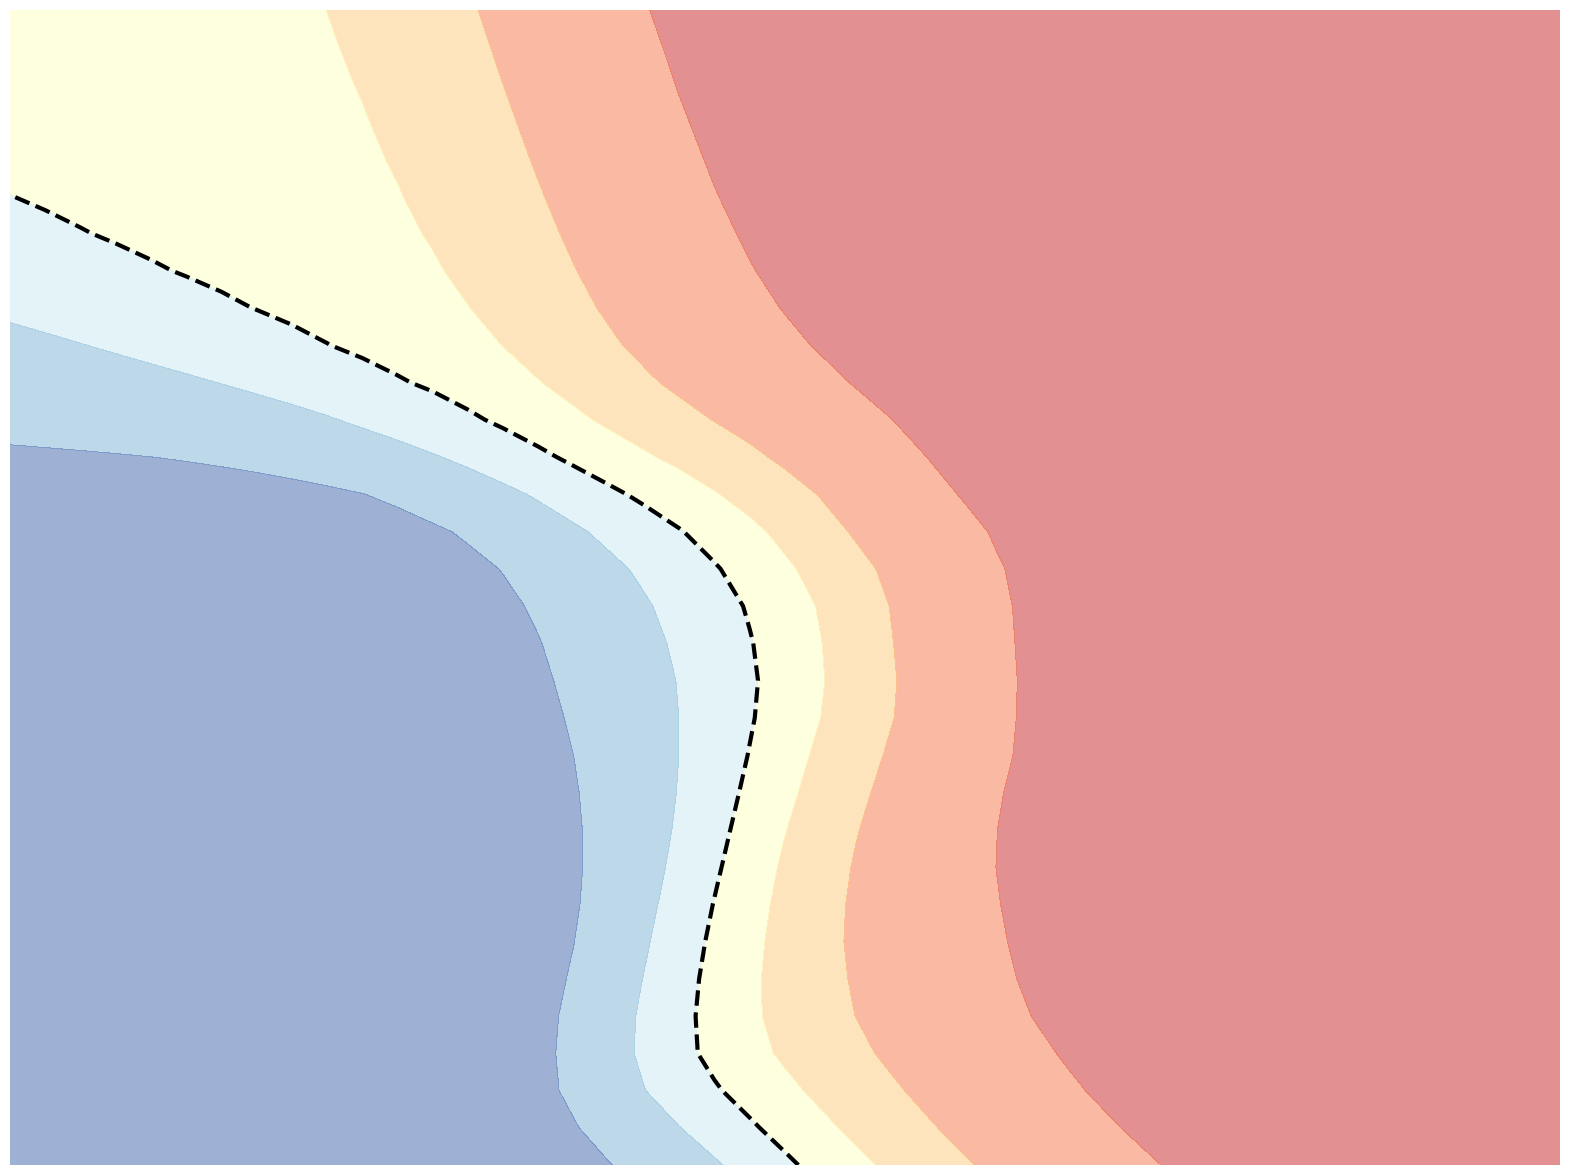

In [319]:
get_background()

In [320]:
offset = 0.45
base_x = [-1, -0.5 + offset]
base_cf = [0.55, -0.3 + offset]

In [321]:
def figure1():
    # get the background
    fig, ax = get_background()

    # Add the base x
    plt.scatter(
        base_x[0], base_x[1], label="Base x", color="black", marker="o", s=300, alpha=1
    )

    # Add the base cf
    plt.scatter(
        base_cf[0],
        base_cf[1],
        label="Base CF",
        color="white",
        marker="o",
        s=300,
        alpha=1,
        edgecolors="black",
        linewidth=3,
    )

    # Draw the arrow
    plt.arrow(
        base_x[0] + 0.07,
        base_x[1] + 0.006,
        base_cf[0] - base_x[0] - 0.18,
        base_cf[1] - base_x[1] - 0.02,
        head_width=0.05,
        head_length=0.05,
        fc="black",
        ec="black",
        alpha=1,
        linestyle="-",
        linewidth=3,
    )

    return fig, ax

Original data point (black) and the base counterfactual explanation (white with black border)


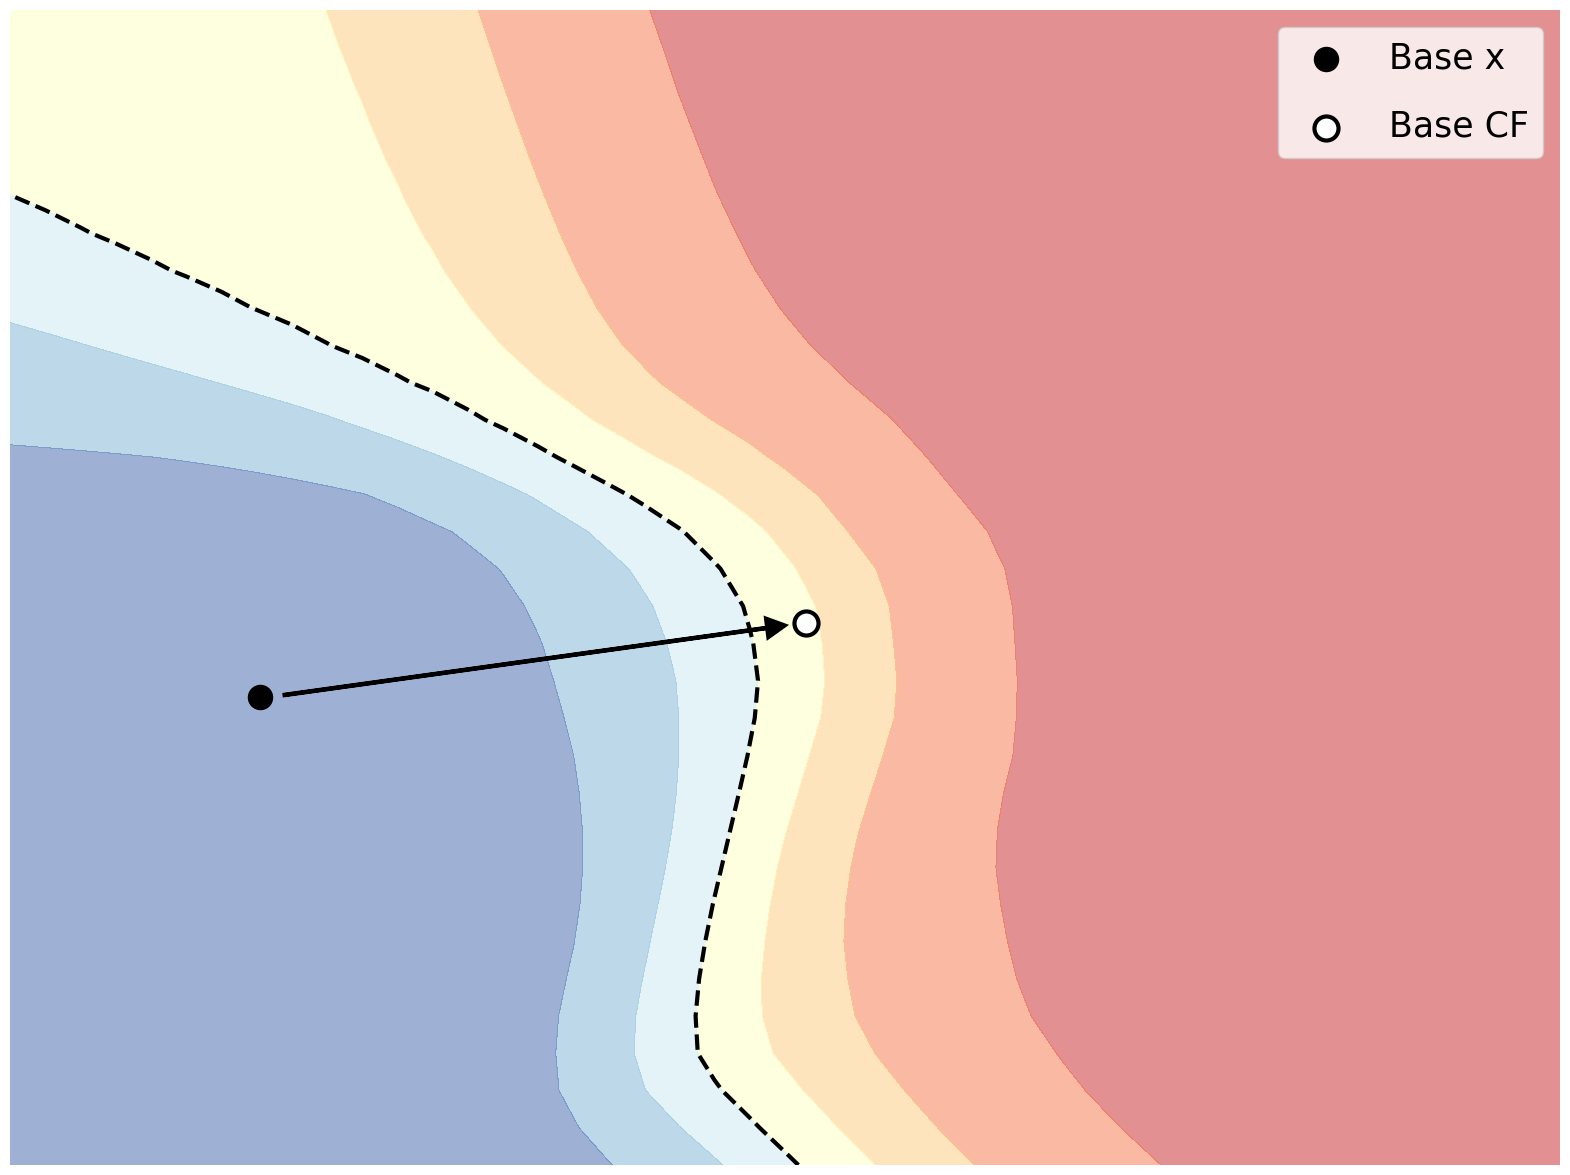

In [322]:
figure1()
plt.legend(fontsize=25, labelspacing=1, loc="upper right")
caption = """Original data point (black) and the base counterfactual explanation (white with black border)"""
print(caption)
plt.savefig("images/paper/figure1.png", dpi=300, bbox_inches="tight")

In [ ]:
def figure1_1():
    # Now we revert back to raw candidates but we draw a bigger circle around the base cf
    fig, ax = figure1()

    rs = np.array([1.3, 0.9, 1.12, 0.9, 0.7])
    r = 1.4
    theta = [3.9, 1.7, 6.6, 9.3, 4.5]

    x = rs * np.cos(theta) + base_cf[0]
    y = rs * np.sin(theta) + base_cf[1]

    circle = plt.Circle(
        (base_cf[0], base_cf[1]),
        r,
        color="gray",
        fill=True,
        linestyle="--",
        linewidth=3,
        alpha=0.5,
        label="Sampling region",
    )

    plt.scatter(
        x,
        y,
        color="gray",
        marker="o",
        s=300,
        alpha=1,
        edgecolors="black",
        linewidth=3,
        label="Candidates",
    )

    ax.add_artist(circle)

    # Adjust the zorder of the circles
    circle.set_zorder(-1)

    return fig, ax, zip(x, y)


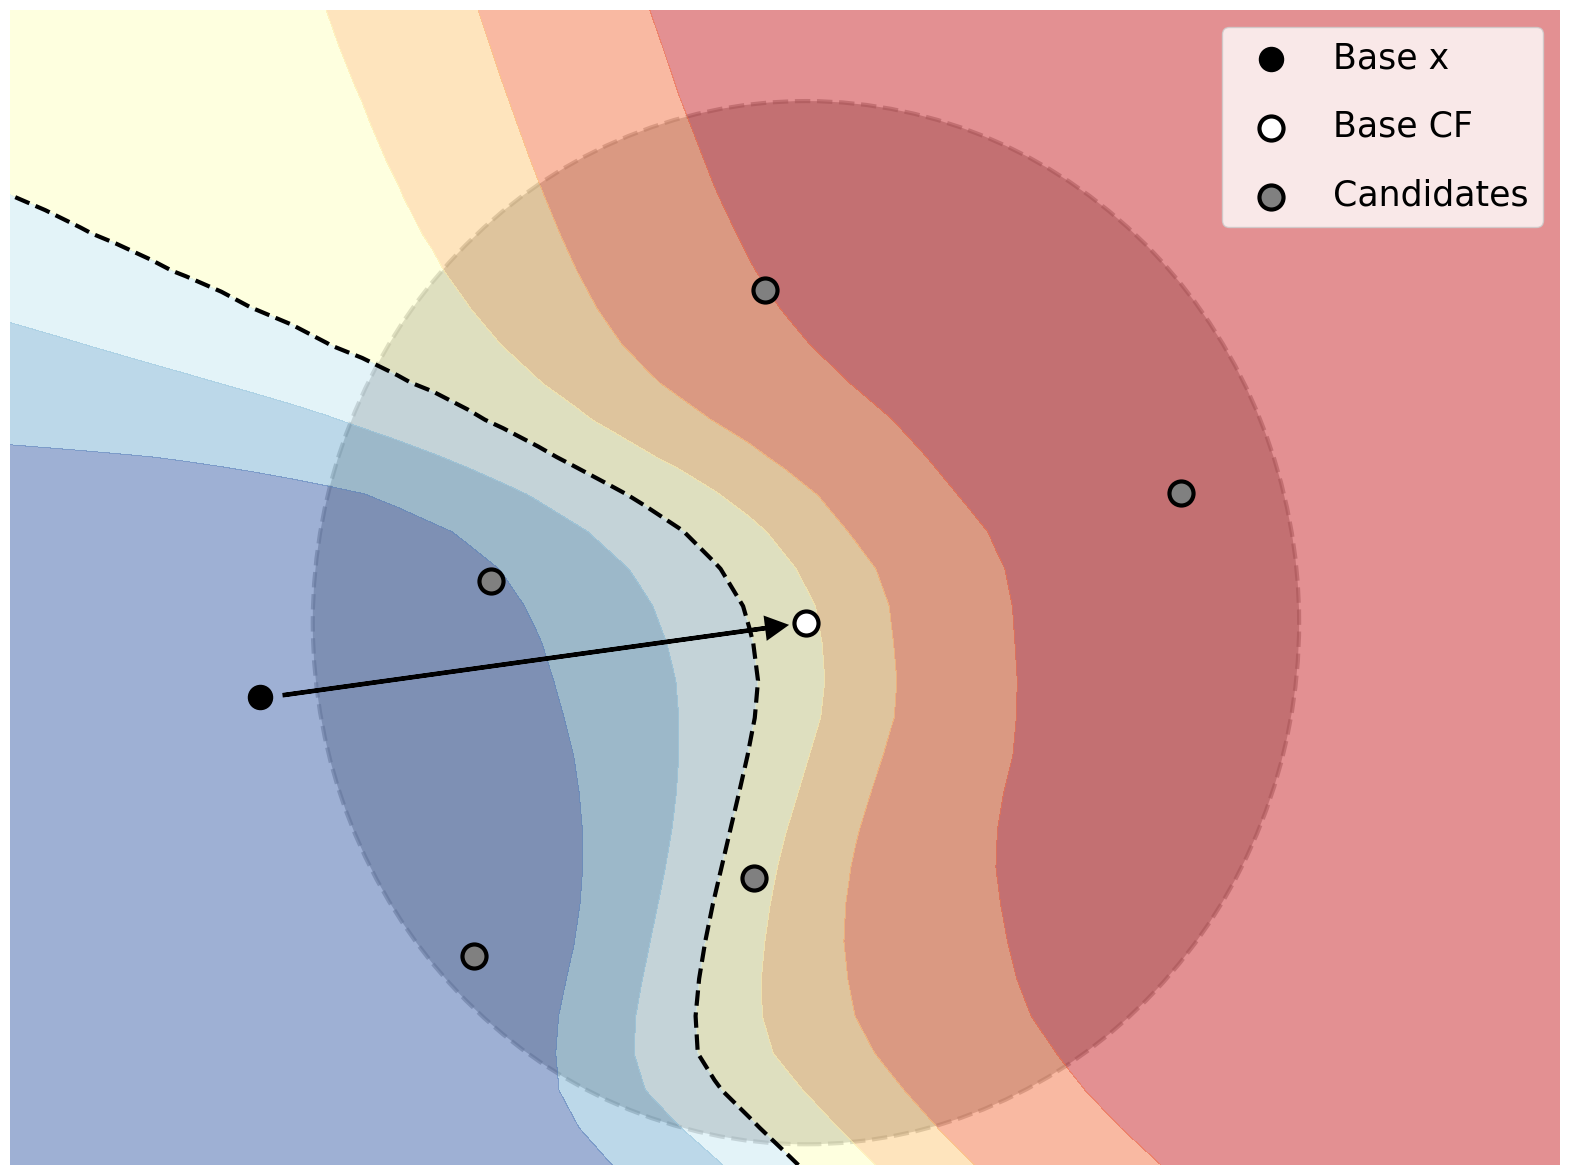

In [324]:
figure1_1()
plt.legend(fontsize=25, labelspacing=1, loc="upper right")
plt.savefig("images/paper/figure1_1.png", dpi=300, bbox_inches="tight")

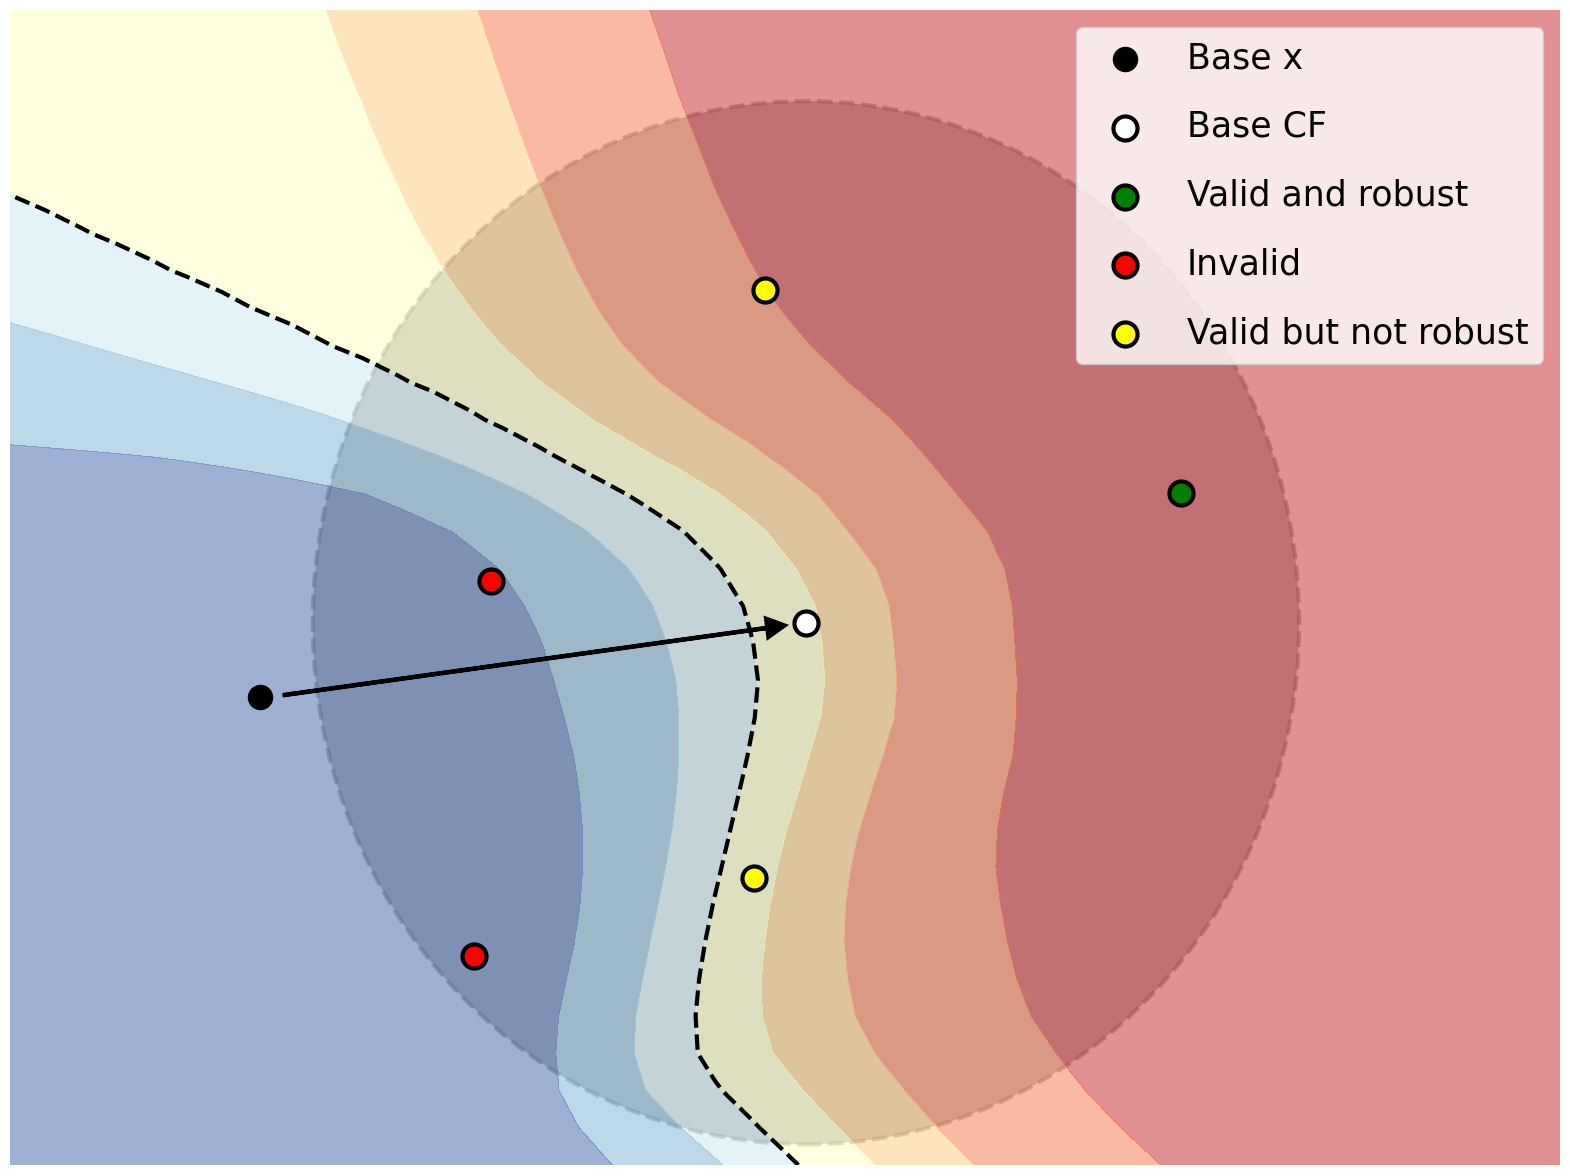

In [ ]:
def figure1_2():
    # Now we revert back to raw candidates but we draw a bigger circle around the base cf
    fig, ax = figure1()

    rs = np.array([1.3, 0.9, 1.12, 0.9, 0.7])
    r = 1.4
    theta = [3.9, 1.7, 6.6, 9.3, 4.5]

    x = rs * np.cos(theta) + base_cf[0]
    y = rs * np.sin(theta) + base_cf[1]

    circle = plt.Circle(
        (base_cf[0], base_cf[1]),
        r,
        color="gray",
        fill=True,
        linestyle="--",
        linewidth=3,
        alpha=0.5,
        label="Sampling region",
    )
    samples = np.array(list(zip(x, y)))
    mask = samples[:, 0] > base_cf[0] + 0.1
    mask2 = samples[:, 0] < base_cf[0] - 0.5

    plt.scatter(
        samples[mask, 0],
        samples[mask, 1],
        color="green",
        marker="o",
        s=300,
        alpha=1,
        edgecolors="black",
        linewidth=3,
        label="Valid and robust",
    )

    plt.scatter(
        samples[mask2, 0],
        samples[mask2, 1],
        color="red",
        marker="o",
        s=300,
        alpha=1,
        edgecolors="black",
        linewidth=3,
        label="Invalid",
    )

    plt.scatter(
        samples[~mask & ~mask2, 0],
        samples[~mask & ~mask2, 1],
        color="yellow",
        marker="o",
        s=300,
        alpha=1,
        edgecolors="black",
        linewidth=3,
        label="Valid but not robust",
    )

    ax.add_artist(circle)

    # Adjust the zorder of the circles
    circle.set_zorder(-1)

    return fig, ax, zip(x, y)


figure1_2()
plt.legend(fontsize=25, labelspacing=1, loc="upper right")
plt.savefig("images/paper/figure1_2.png", dpi=300, bbox_inches="tight")

In [326]:
def figure2():
    fig, ax = figure1()
    r = 0.5
    rs = np.array([0.47, 0.4, 0.3, 0.2, 0.3])
    theta = [0, 4, 1, 7, 3.8]

    x = rs * np.cos(theta) + base_cf[0]
    y = rs * np.sin(theta) + base_cf[1]

    circle = plt.Circle(
        (base_cf[0], base_cf[1]),
        r,
        color="gray",
        fill=True,
        linestyle="--",
        linewidth=3,
        alpha=0.5,
        label="Sampling region",
    )
    # adjust zorder of the circle
    circle.set_zorder(-1)

    plt.scatter(
        x,
        y,
        color="gray",
        marker="o",
        s=300,
        alpha=1,
        edgecolors="black",
        linewidth=3,
        label="Candidates",
    )

    samples = zip(x, y)

    ax.add_artist(circle)
    return fig, ax, samples

Candidates for the counterfactual explanation (gray)


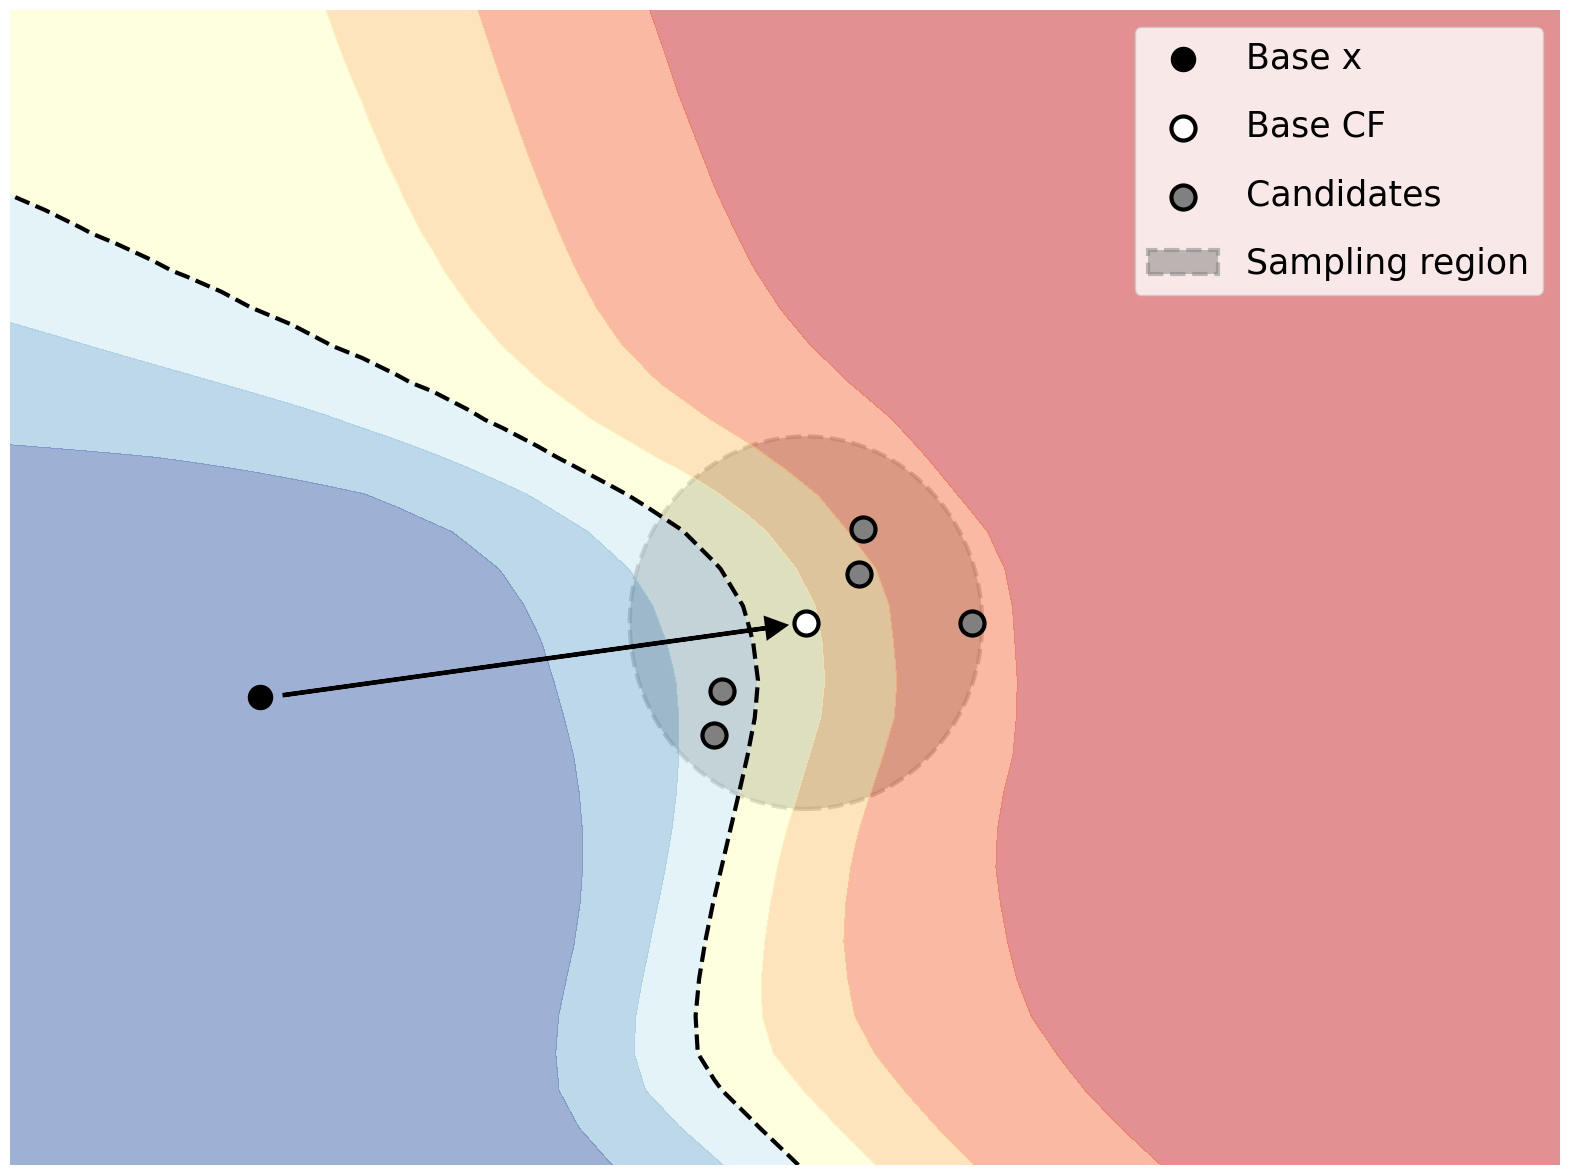

In [327]:
figure2()
plt.legend(fontsize=25, labelspacing=1, loc="upper right")
caption = """Candidates for the counterfactual explanation (gray)"""
print(caption)
plt.savefig("images/paper/figure2.png", dpi=300, bbox_inches="tight")

Valid and invalid candidates for the counterfactual explanation


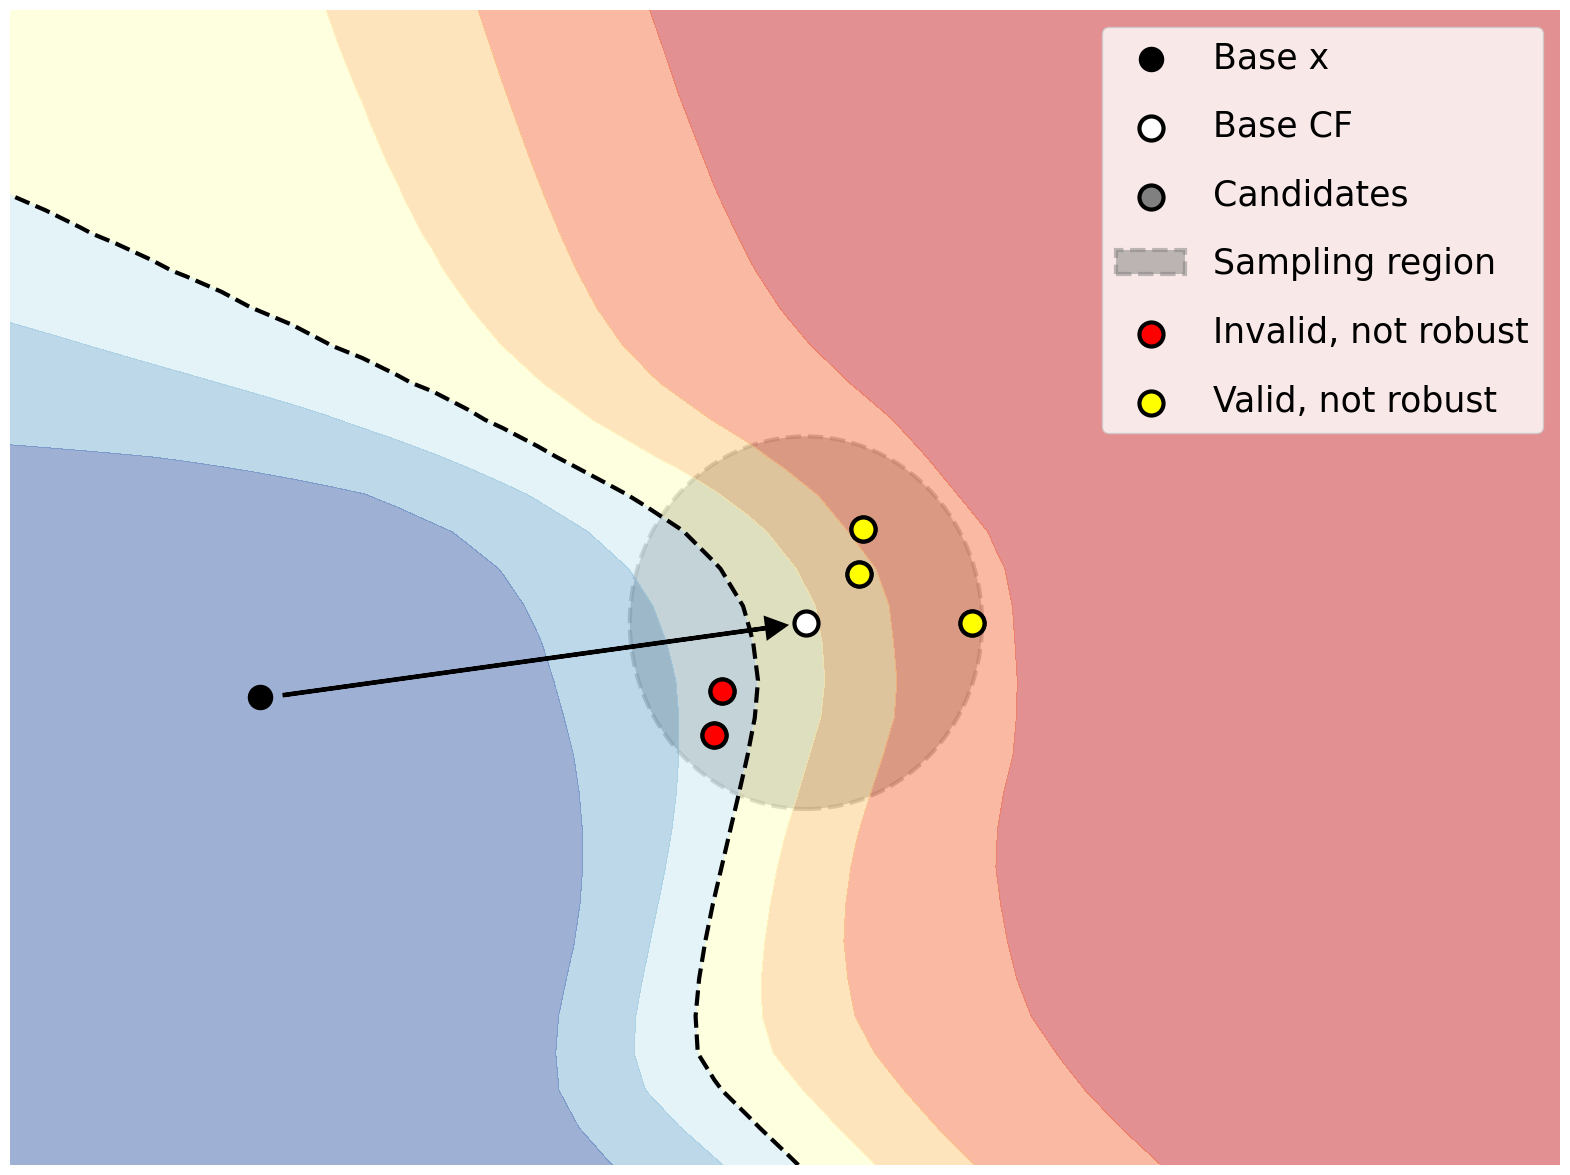

In [328]:
fig, ax, samples = figure2()
samples = np.array(list(samples))
# Change the color of the samples if they are to the left of the base cf

mask = samples[:, 0] < base_cf[0] - 0.1
mask = mask.astype(int)
plt.scatter(
    samples[:, 0][mask == 1],
    samples[:, 1][mask == 1],
    color="red",
    marker="o",
    s=300,
    alpha=1,
    edgecolors="black",
    linewidth=3,
    label="Invalid, not robust",
)

plt.scatter(
    samples[:, 0][mask == 0],
    samples[:, 1][mask == 0],
    color="yellow",
    marker="o",
    s=300,
    alpha=1,
    edgecolors="black",
    linewidth=3,
    label="Valid, not robust",
)

plt.legend(fontsize=25, labelspacing=1, loc="upper right")
caption = """Valid and invalid candidates for the counterfactual explanation"""
print(caption)
plt.savefig("images/paper/figure3.png", dpi=300, bbox_inches="tight")

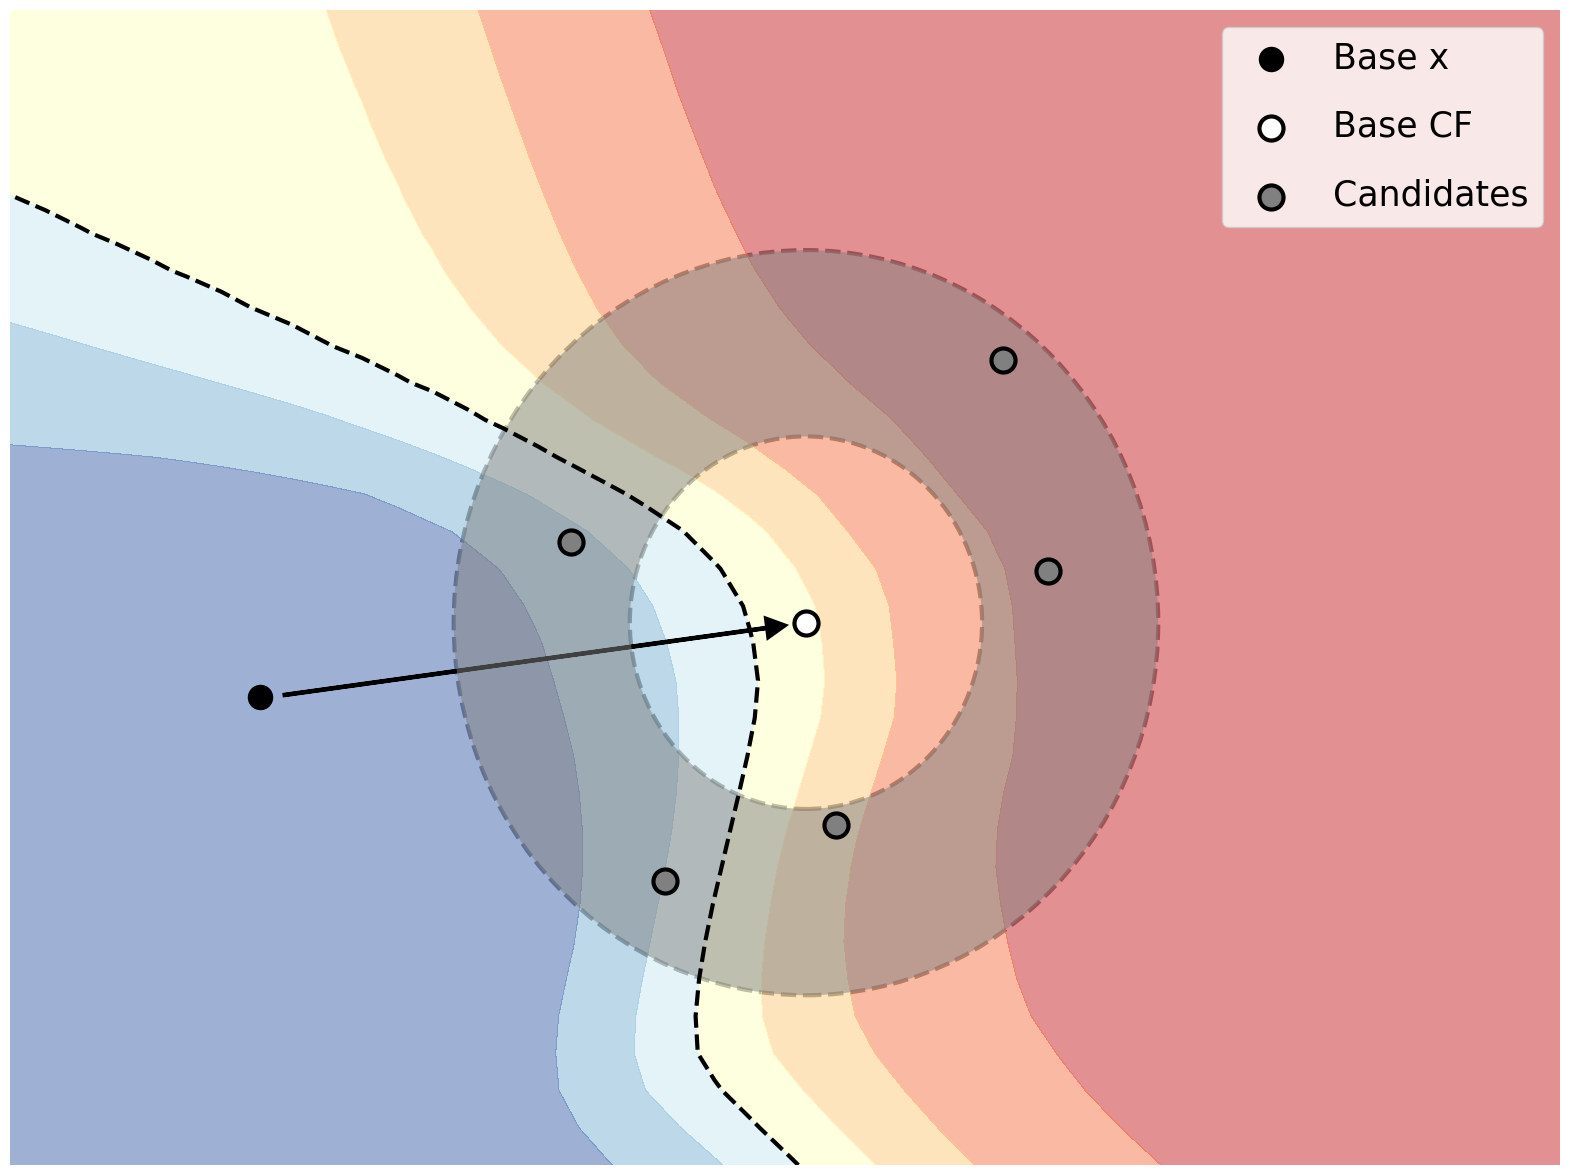

In [329]:
def figure4():
    # Now we revert back to raw candidates but we draw a bigger circle around the base cf
    fig, ax = figure1()

    rs = np.array([0.7, 0.9, 0.55, 0.7, 0.8])
    r = 1.0
    r_small = 0.5
    theta = [0.2, 0.9, 3.1 * np.pi / 2, 0.9 * np.pi, 8 * np.pi / 6]

    x = rs * np.cos(theta) + base_cf[0]
    y = rs * np.sin(theta) + base_cf[1]

    circle = plt.Circle(
        (base_cf[0], base_cf[1]),
        r,
        color="gray",
        fill=False,
        linestyle="--",
        linewidth=3,
    )

    circle_small = plt.Circle(
        (base_cf[0], base_cf[1]),
        r_small,
        color="gray",
        fill=False,
        linestyle="--",
        linewidth=3,
    )

    # Fill the area between the outer and inner circle
    # Do it as a polygon of the two circles
    samples_outer = np.linspace(0, 2 * np.pi, 100)
    samples_inner = np.linspace(0, 2 * np.pi, 100)

    x_outer = r * np.cos(samples_outer) + base_cf[0]
    y_outer = r * np.sin(samples_outer) + base_cf[1]

    x_inner = r_small * np.cos(samples_inner) + base_cf[0]
    y_inner = r_small * np.sin(samples_inner) + base_cf[1]

    polygon_x = np.concatenate([x_outer, x_inner[::-1]])
    polygon_y = np.concatenate([y_outer, y_inner[::-1]])

    f = plt.fill(polygon_x, polygon_y, color="gray", alpha=0.5)
    f[0].set_edgecolor("none")

    plt.scatter(
        x,
        y,
        color="gray",
        marker="o",
        s=300,
        alpha=1,
        edgecolors="black",
        linewidth=3,
        label="Candidates",
    )

    ax.add_artist(circle)
    ax.add_artist(circle_small)

    # Adjust the zorder of the circles
    circle.set_zorder(-1)
    circle_small.set_zorder(-2)

    return fig, ax, zip(x, y)


figure4()
plt.legend(fontsize=25, labelspacing=1, loc="upper right")
plt.savefig("images/paper/figure4.png", dpi=300, bbox_inches="tight")

Valid and invalid candidates for the counterfactual explanation


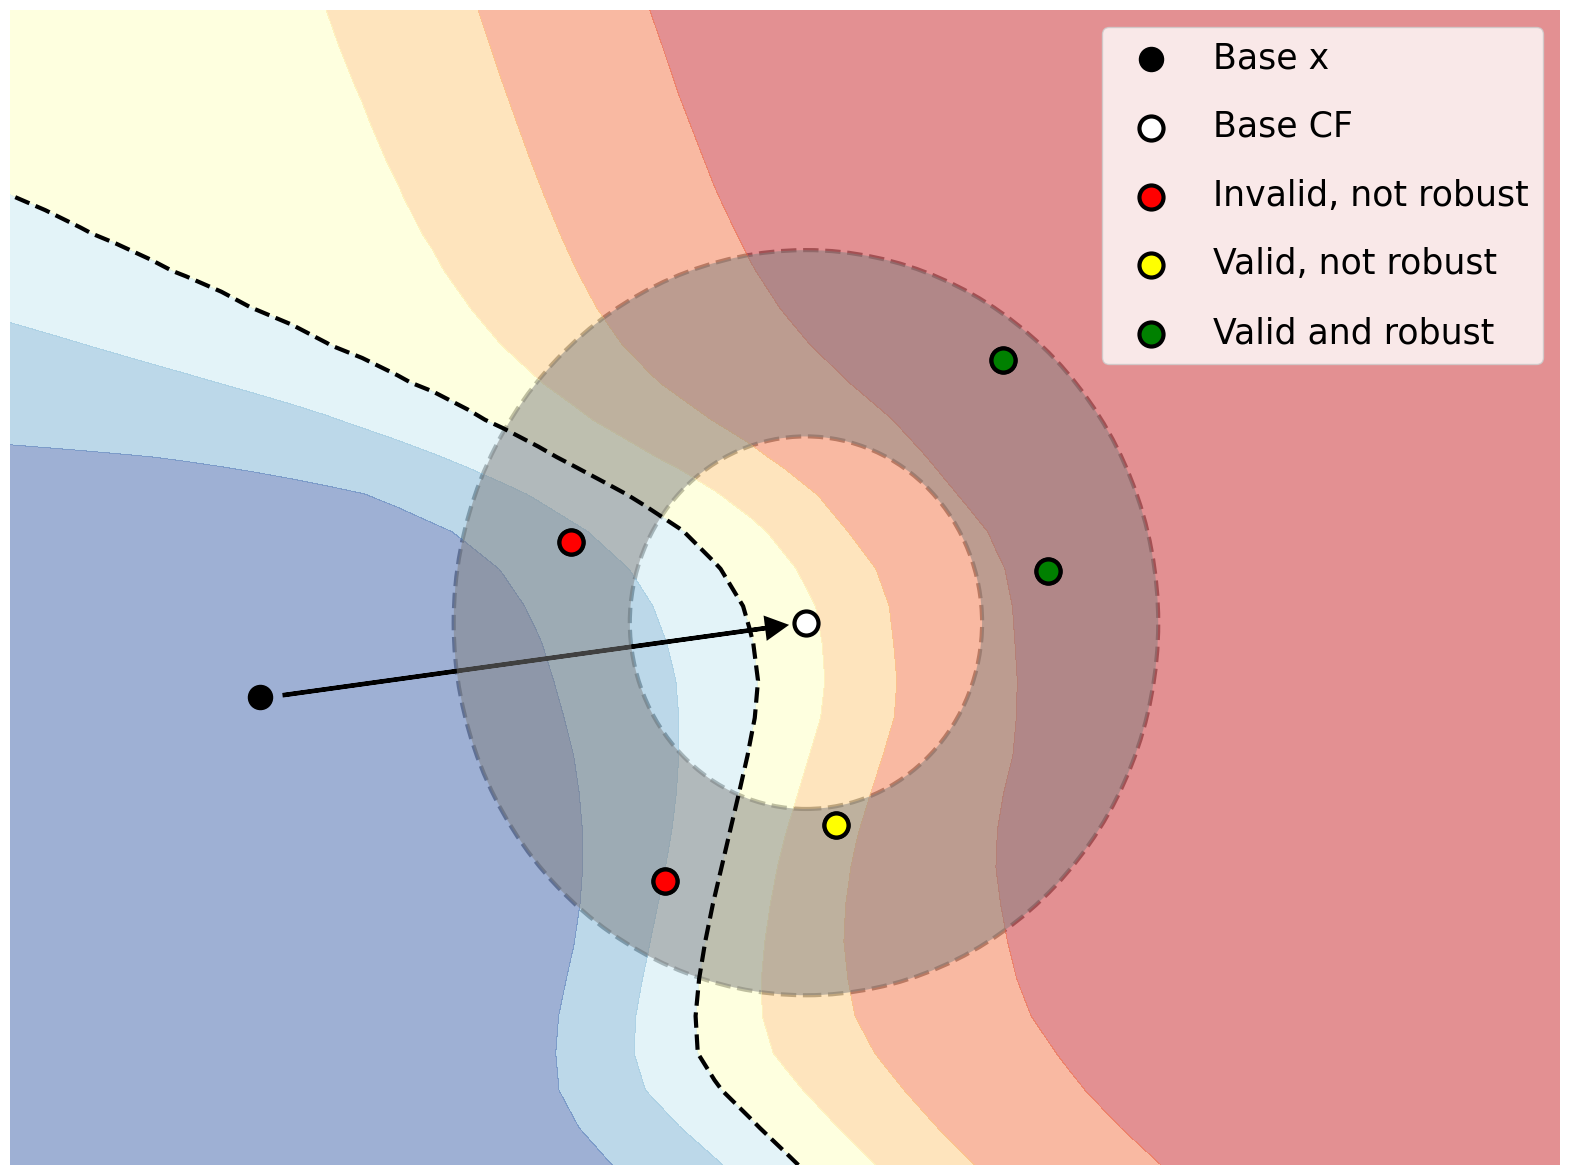

In [330]:
def figure5():
    fig, ax, samples = figure4()

    samples = np.array(list(samples))
    # Change the color of the samples if they are to the left of the base cf

    mask = samples[:, 0] < base_cf[0] - 0.1
    mask = mask.astype(int)

    plt.scatter(
        samples[:, 0][mask == 1],
        samples[:, 1][mask == 1],
        color="red",
        marker="o",
        s=300,
        alpha=1,
        edgecolors="black",
        linewidth=3,
        label="Invalid, not robust",
    )

    mask2 = (samples[:, 0] > base_cf[0]) & (samples[:, 0] < base_cf[0] + 0.2)
    mask2 = mask2.astype(int)

    plt.scatter(
        samples[:, 0][mask2 == 1],
        samples[:, 1][mask2 == 1],
        color="yellow",
        marker="o",
        s=300,
        alpha=1,
        edgecolors="black",
        linewidth=3,
        label="Valid, not robust",
    )

    plt.scatter(
        samples[:, 0][(mask == 0) & (mask2 == 0)],
        samples[:, 1][(mask == 0) & (mask2 == 0)],
        color="green",
        marker="o",
        s=300,
        alpha=1,
        edgecolors="black",
        linewidth=3,
        label="Valid and robust",
    )

    robust_samples = samples[(mask == 0) & (mask2 == 0)]
    return fig, ax, robust_samples


fig, ax, robust_samples = figure5()
# skip the third elemnt from legend
handles, labels = ax.get_legend_handles_labels()
plt.legend(
    handles[:2] + handles[3:],
    labels[:2] + labels[3:],
    fontsize=25,
    labelspacing=1,
    loc="upper right",
)

# plt.legend(fontsize=25, labelspacing=1, loc="upper right")
caption = """Valid and invalid candidates for the counterfactual explanation"""
print(caption)
plt.savefig("images/paper/figure5.png", dpi=300, bbox_inches="tight")

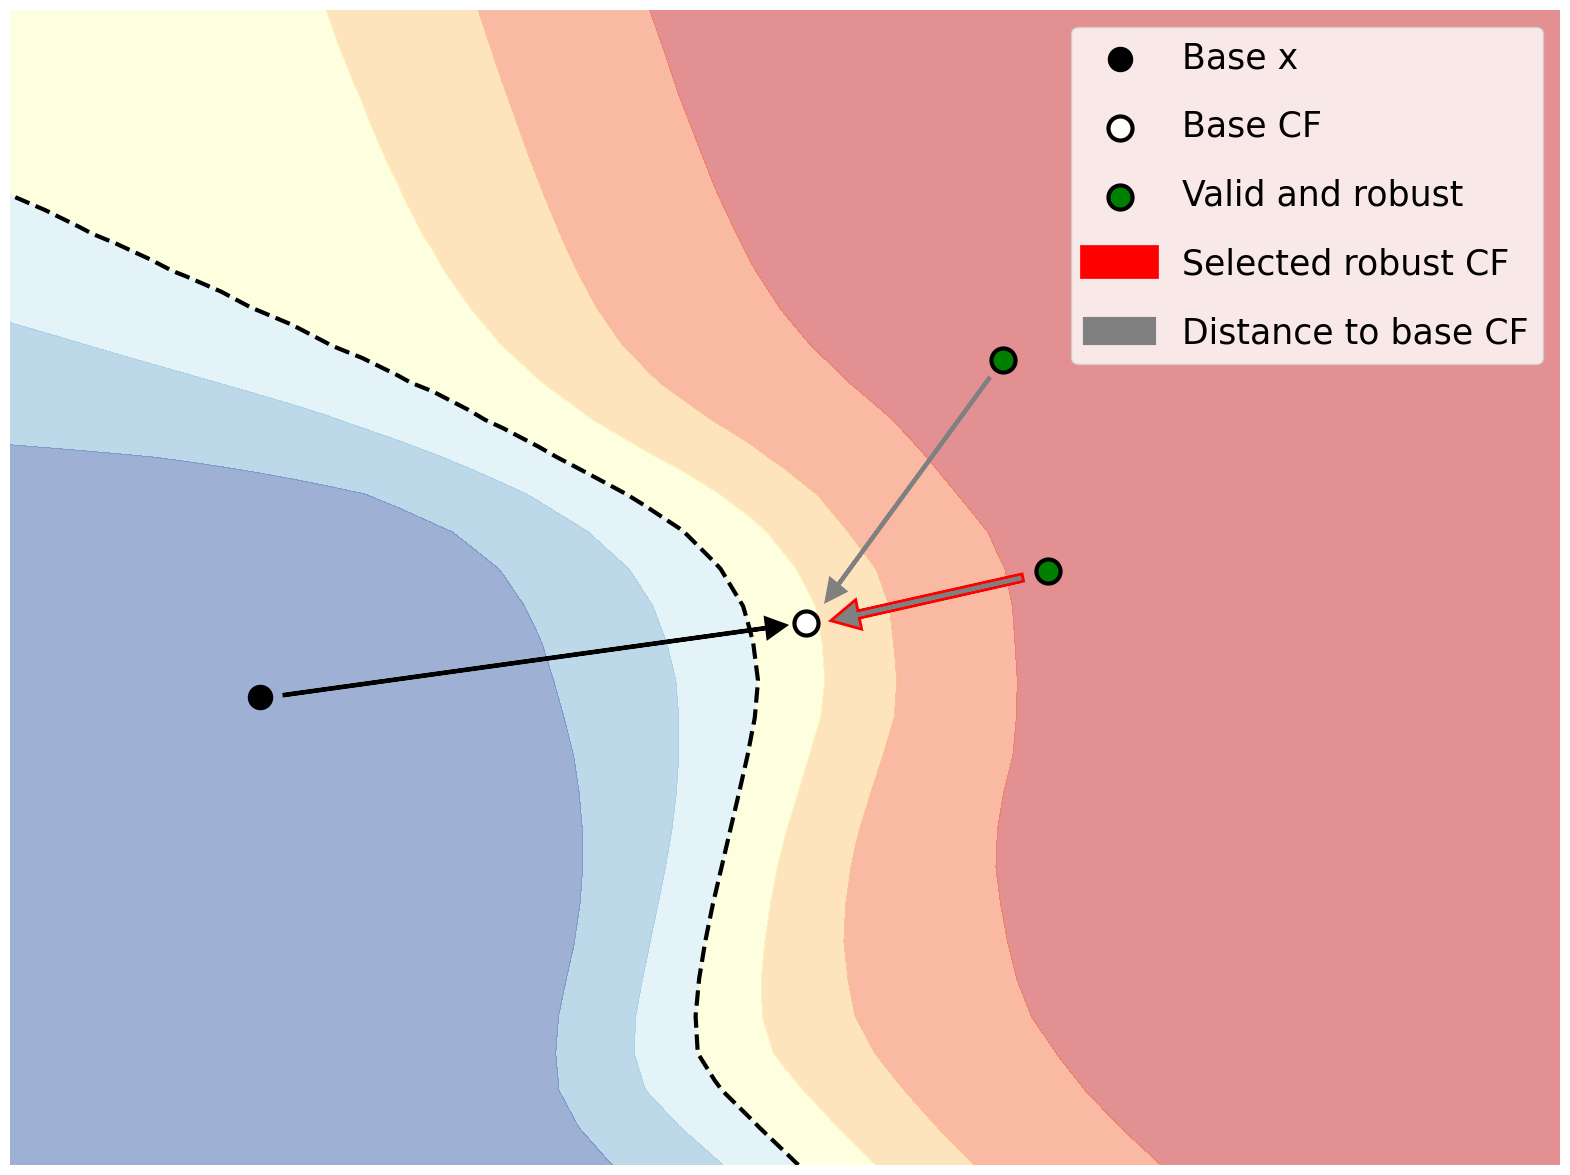

In [331]:
fig, ax = figure1()

plt.scatter(
    robust_samples[:, 0],
    robust_samples[:, 1],
    color="green",
    marker="o",
    s=300,
    alpha=1,
    edgecolors="black",
    linewidth=3,
    label="Valid and robust",
)

# Select arrow 1 by highlighting its outline in red via a trick
# which is to plot the arrow again with a bigger linewidth
plt.arrow(
    robust_samples[0][0] - 0.08,
    robust_samples[0][1] - 0.02,
    base_cf[0] - robust_samples[0][0] + 0.22,
    base_cf[1] - robust_samples[0][1] + 0.04,
    head_width=0.05,
    head_length=0.05,
    fc="red",
    ec="red",
    alpha=1,
    linestyle="-",
    linewidth=7,
    label="Selected robust CF",
)

# Draw the arrow from robust samples to base cf
arr1 = plt.arrow(
    robust_samples[0][0] - 0.08,
    robust_samples[0][1] - 0.02,
    base_cf[0] - robust_samples[0][0] + 0.22,
    base_cf[1] - robust_samples[0][1] + 0.04,
    head_width=0.05,
    head_length=0.05,
    fc="gray",
    ec="gray",
    alpha=1,
    linestyle="-",
    linewidth=3,
    label="Distance to base CF",
)

arr2 = plt.arrow(
    robust_samples[1][0] - 0.04,
    robust_samples[1][1] - 0.05,
    base_cf[0] - robust_samples[1][0] + 0.13,
    base_cf[1] - robust_samples[1][1] + 0.15,
    head_width=0.05,
    head_length=0.05,
    fc="gray",
    ec="gray",
    alpha=1,
    linestyle="-",
    linewidth=3,
)


plt.legend(fontsize=25, labelspacing=1, loc="upper right")
plt.savefig("images/paper/figure6.png", dpi=300, bbox_inches="tight")

In [332]:
from PIL import Image

# List of image file paths
images = [
    "images/paper/figure1.png",
    "images/paper/figure1_1.png",
    "images/paper/figure1_2.png",
    "images/paper/figure2.png",
    "images/paper/figure3.png",
    "images/paper/figure4.png",
    "images/paper/figure5.png",
    "images/paper/figure6.png",
]

# Open the images and convert them to RGBA format (if not already in that format)
frames = [Image.open(image).convert("RGBA") for image in images]

# Save as a GIF
frames[0].save(
    "images/paper/algorithm.gif",
    save_all=True,
    append_images=frames[1:],  # Additional frames
    duration=1800,  # Duration per frame (ms)
    loop=0,  # 0 means infinite loop
)

print("GIF saved as output.gif")


GIF saved as output.gif
